Поиск моделей для предсказания цен на акции и направления сделки (покупка/продажа), генерация признаков.

# Загрузка библиотек

In [ ]:
# данные
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import math

# визуализация
from matplotlib import pyplot as plt
import seaborn as sns

# подготовка данных
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# метрики
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error as me
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import r2_score

# регресия
from sklearn.linear_model import LinearRegression, Lasso
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# классификация
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# Загрузка данных

In [ ]:
# прочитаем файл csv с историческими данными
parse_dates = ['<DATE>']
data = pd.read_csv('SBER_100101_211231.csv', parse_dates=parse_dates)
data.drop(columns=['<PER>', '<TIME>'], inplace=True)
data.head(2)

,<TICKER>,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SBER,2010-01-11,86.560,88.170,85.510,86.690,148661237
1,SBER,2010-01-12,86.550,86.770,84.900,85.000,130276079


In [ ]:
# переименуем названия признаков в более удобные
data.rename(columns={'<TICKER>':'TICKER', '<DATE>':'DATE', '<OPEN>':'OPEN', '<HIGH>':'HIGH', 
                     '<LOW>':'LOW', '<CLOSE>':'CLOSE', '<VOL>':'VOL'}, inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3016 entries, 0 to 3015
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TICKER  3016 non-null   object        
 1   DATE    3016 non-null   datetime64[ns]
 2   OPEN    3016 non-null   float64       
 3   HIGH    3016 non-null   float64       
 4   LOW     3016 non-null   float64       
 5   CLOSE   3016 non-null   float64       
 6   VOL     3016 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 165.1+ KB


# Feature engineering

На основе имеющихся признаков придумаем новые. Оформим в виде функции.

In [ ]:
def features(data):

    # день недели
    data['DAY_OF_WEEK'] = data['DATE'].dt.dayofweek

    # месяц
    data['MONTH'] = data['DATE'].dt.month
    
    # разность между ценой открытия и закрытия
    data['DIF_O_C'] = data['OPEN'] - data['CLOSE']
    
    # разность между максимальной и минимальной ценой
    data['DIF_H_L'] = data['HIGH'] - data['LOW']

    # средние цены закрытия за ... дней
    data['MEAN_2'] = data['CLOSE'].rolling(window=2, center=False).mean()
    data['MEAN_3'] = data['CLOSE'].rolling(window=3, center=False).mean()
    data['MEAN_4'] = data['CLOSE'].rolling(window=4, center=False).mean()
    data['MEAN_5'] = data['CLOSE'].rolling(window=5, center=False).mean()

    # максимальные цены за ... дней
    data['HIGH_2'] = data['HIGH'].rolling(window=2, center=False).max()
    data['HIGH_3'] = data['HIGH'].rolling(window=3, center=False).max()
    data['HIGH_4'] = data['HIGH'].rolling(window=4, center=False).max()
    data['HIGH_5'] = data['HIGH'].rolling(window=5, center=False).max()

    # минимальные цены за ... дней
    data['LOW_2'] = data['LOW'].rolling(window=2, center=False).min()
    data['LOW_3'] = data['LOW'].rolling(window=3, center=False).min()
    data['LOW_4'] = data['LOW'].rolling(window=4, center=False).min()
    data['LOW_5'] = data['LOW'].rolling(window=5, center=False).min()
    
    # цены и объем за прошлые дни
    data[['OPEN-1', 'HIGH-1', 'LOW-1', 'CLOSE-1', 'VOL-1']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(1)
    data[['OPEN-2', 'HIGH-2', 'LOW-2', 'CLOSE-2', 'VOL-2']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(2)
    data[['OPEN-3', 'HIGH-3', 'LOW-3', 'CLOSE-3', 'VOL-3']] = data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL']].shift(3)
    
    # цена открытия сегодня
    data['OPEN_TODAY'] = data['OPEN'].shift(-1)

    return pd.get_dummies(data, columns=['DAY_OF_WEEK', 'MONTH'], prefix=['DAY_OF_WEEK', 'MONTH'])

In [ ]:
data = features(data)
data.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL,DIF_O_C,DIF_H_L,MEAN_2,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,SBER,2010-01-11,86.560,88.170,85.510,86.690,148661237,-0.130,2.660,NaN,...,0,0,0,0,0,0,0,0,0,0
1,SBER,2010-01-12,86.550,86.770,84.900,85.000,130276079,1.550,1.870,85.845,...,0,0,0,0,0,0,0,0,0,0
2,SBER,2010-01-13,84.400,87.230,84.100,86.610,128684773,-2.210,3.130,85.805,...,0,0,0,0,0,0,0,0,0,0
3,SBER,2010-01-14,87.500,87.870,86.750,87.550,111263614,-0.050,1.120,87.080,...,0,0,0,0,0,0,0,0,0,0
4,SBER,2010-01-15,87.470,88.670,87.160,88.150,142060148,-0.680,1.510,87.850,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.columns

Index(['TICKER', 'DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'DIF_O_C',
       'DIF_H_L', 'MEAN_2', 'MEAN_3', 'MEAN_4', 'MEAN_5', 'HIGH_2', 'HIGH_3',
       'HIGH_4', 'HIGH_5', 'LOW_2', 'LOW_3', 'LOW_4', 'LOW_5', 'OPEN-1',
       'HIGH-1', 'LOW-1', 'CLOSE-1', 'VOL-1', 'OPEN-2', 'HIGH-2', 'LOW-2',
       'CLOSE-2', 'VOL-2', 'OPEN-3', 'HIGH-3', 'LOW-3', 'CLOSE-3', 'VOL-3',
       'OPEN_TODAY', 'DAY_OF_WEEK_0', 'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2',
       'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object')

# Целевой признак

Подготовим два целевых признака. \
Для задачи классификации: где произойдет закрытие - выше открытия (класс 1) или ниже (класс 0)\
Для задачи регрессии: предсказание цены закрытия/максимума/минимума 

In [ ]:
# целевой признак для регресии - это цена закрытия/максимум/минимум дня
# добавим его смещением колонки с ценой закрытия вверх на единицу
data['TARGET_CLOSE'] = data['CLOSE'].shift(-1)
data['TARGET_HIGH'] = data['HIGH'].shift(-1)
data['TARGET_LOW'] = data['LOW'].shift(-1)
data[['OPEN', 'HIGH',	'LOW', 'CLOSE', 'OPEN_TODAY', 'TARGET_HIGH', 'TARGET_LOW', 'TARGET_CLOSE']].head(5)

,OPEN,HIGH,LOW,CLOSE,OPEN_TODAY,TARGET_HIGH,TARGET_LOW,TARGET_CLOSE
0,86.560,88.170,85.510,86.690,86.550,86.770,84.900,85.000
1,86.550,86.770,84.900,85.000,84.400,87.230,84.100,86.610
2,84.400,87.230,84.100,86.610,87.500,87.870,86.750,87.550
3,87.500,87.870,86.750,87.550,87.470,88.670,87.160,88.150
4,87.470,88.670,87.160,88.150,87.860,90.650,87.790,90.490


In [ ]:
# целевой признак для классификации - закрытие выше (1) или ниже (0) открытия
data['TARGET_UP_DOWN'] = data.apply(lambda x: 1 if x['TARGET_CLOSE'] > x['OPEN_TODAY'] else 0,  axis=1)
data[['OPEN', 'CLOSE', 'OPEN_TODAY', 'TARGET_CLOSE', 'TARGET_UP_DOWN']].head(5)

,OPEN,CLOSE,OPEN_TODAY,TARGET_CLOSE,TARGET_UP_DOWN
0,86.560,86.690,86.550,85.000,0
1,86.550,85.000,84.400,86.610,1
2,84.400,86.610,87.500,87.550,1
3,87.500,87.550,87.470,88.150,1
4,87.470,88.150,87.860,90.490,1


In [ ]:
data.TARGET_UP_DOWN.value_counts()

0    1561
1    1455
Name: TARGET_UP_DOWN, dtype: int64

Закрытий по обе стороны примерно одинаковое количество.

In [ ]:
# избавимся от nan-ов
data = data.dropna()

# Классификация

Обучим сразу несколько моделей "из коробки"

In [ ]:
# предикторы
X = data.drop(columns=['TICKER', 'DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW',  'TARGET_UP_DOWN'])
# целевой признак
y = data['TARGET_UP_DOWN']

# разделим на трейн и тест без перемешивания
# учимся на более ранних данных, тестируем на более поздних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [ ]:
X.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'DIF_O_C', 'DIF_H_L', 'MEAN_2',
       'MEAN_3', 'MEAN_4', 'MEAN_5', 'HIGH_2', 'HIGH_3', 'HIGH_4', 'HIGH_5',
       'LOW_2', 'LOW_3', 'LOW_4', 'LOW_5', 'OPEN-1', 'HIGH-1', 'LOW-1',
       'CLOSE-1', 'VOL-1', 'OPEN-2', 'HIGH-2', 'LOW-2', 'CLOSE-2', 'VOL-2',
       'OPEN-3', 'HIGH-3', 'LOW-3', 'CLOSE-3', 'VOL-3', 'OPEN_TODAY',
       'DAY_OF_WEEK_0', 'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3',
       'DAY_OF_WEEK_4', 'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'MONTH_1', 'MONTH_2',
       'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8',
       'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'],
      dtype='object')

In [ ]:
cls_models = [
            LogisticRegression(random_state=10),
            RandomForestClassifier (random_state=10),
            LinearDiscriminantAnalysis(),
            KNeighborsClassifier(),
            GaussianNB(),
            SVC(random_state=10),
            GradientBoostingClassifier(random_state=10),
            LGBMClassifier(random_state=10),
            XGBClassifier(random_state=10)
            ]

In [ ]:
# для записи метрик качества (будем считать accuracy) моделей
cls_models_metrics = pd.DataFrame(columns=['model', 'acc'])

# для удобства сведем в отдельный датафрейм:
# цену открытия
# реальную цену закрытия
# предсказанную цену закрытия
#models_close = pd.DataFrame()
#models_close['open'] = X_test['OPEN']
#models_close['close_real'] = y_test


for i, model in enumerate(cls_models):
    print(model, end = '..........')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    
    acc_ = acc (y_test[:-1], y_pred[:-1])
    cls_models_metrics.loc[len(cls_models_metrics.index)] = [model, acc_]
    #models_close[f'close_pred_{i}'] = y_pred
    print('Ok')
cls_models_metrics  

LogisticRegression(random_state=10)..........Ok
RandomForestClassifier(random_state=10)..........Ok
LinearDiscriminantAnalysis()..........Ok
KNeighborsClassifier()..........Ok
GaussianNB()..........Ok
SVC(random_state=10)..........Ok
GradientBoostingClassifier(random_state=10)..........Ok
LGBMClassifier(random_state=10)..........Ok
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_job

,model,acc
0,LogisticRegression(random_state=10),0.519
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.534
2,LinearDiscriminantAnalysis(),0.542
3,KNeighborsClassifier(),0.508
4,GaussianNB(),0.519
5,SVC(random_state=10),0.518
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.519
7,LGBMClassifier(random_state=10),0.535
8,"XGBClassifier(base_score=None, booster=None, c...",0.514


Метрика accuracy чуть-чуть превышает 0,5. Предсказывать получается чуть лучше, чем случайно.\
Посмотроим roc-кривую для одной из моделей.

In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

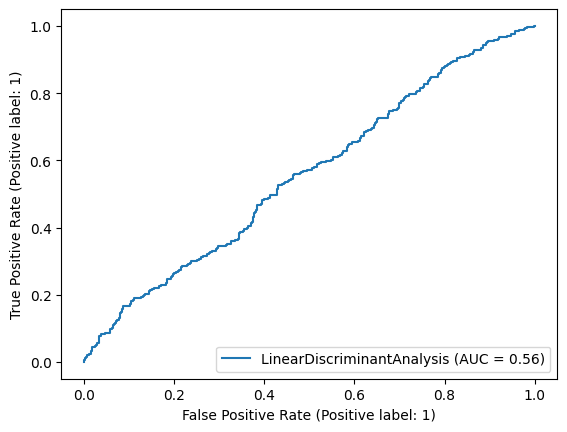

In [ ]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)

# Регрессия

Обучим на предсказание цены закрытия

In [ ]:
# предикторы
X = data.drop(columns=['TICKER', 'DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW', 'TARGET_UP_DOWN'])
# целевой признак
y = data['TARGET_CLOSE']

# разделим на трейн и тест без перемешивания
# учимся на более ранних данных, тестируем на более поздних
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [ ]:
reg_models = [
        LinearRegression(),
        Lasso(),
        LGBMRegressor(random_state=10),
        KernelRidge(),
        ElasticNet(random_state=10),
        BayesianRidge(),
        GradientBoostingRegressor(random_state=10),
        SVR(),
        RandomForestRegressor(random_state=10)
        ]

In [ ]:
# для записи метрик качества моделей
reg_models_metrics = pd.DataFrame(columns=['model', 'mae', 'me', 'r2'])

# для удобства сведем в отдельный датафрейм
models_close = pd.DataFrame()
# цену открытия - open
models_close['open'] = X_test['OPEN']
# реальную цену закрытия - close_real
models_close['close_real'] = y_test
# и предсказанные моделями цены закрытия - close_pred_x

for i, model in enumerate(reg_models):
    print(model, end = '..........')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)    
    mae_ = mae(y_test[:-1], y_pred[:-1])
    me_ = me(y_test[:-1], y_pred[:-1])  
    r2_ = r2_score(y_test[:-1], y_pred[:-1])
    reg_models_metrics.loc[len(reg_models_metrics.index)] = [model, mae_, me_, r2_]
    models_close[f'close_pred_{i}'] = y_pred
    print('Ok')

reg_models_metrics 

LinearRegression()..........Ok
Lasso()..........Ok
LGBMRegressor(random_state=10)..........

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.118e+03, tolerance: 4.440e+02
  model = cd_fast.enet_coordinate_descent(


Ok
KernelRidge()..........

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Ok
ElasticNet(random_state=10)..........Ok
BayesianRidge()..........

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.123e+03, tolerance: 4.440e+02
  model = cd_fast.enet_coordinate_descent(


Ok
GradientBoostingRegressor(random_state=10)..........Ok
SVR()..........Ok
RandomForestRegressor(random_state=10)..........Ok


,model,mae,me,r2
0,LinearRegression(),2.910,28.281,0.993
1,Lasso(),2.970,21.315,0.992
2,LGBMRegressor(random_state=10),13.096,112.988,0.733
3,KernelRidge(),3.430,23.048,0.990
4,ElasticNet(random_state=10),2.969,21.941,0.992
5,BayesianRidge(),2.885,27.772,0.993
6,([DecisionTreeRegressor(criterion='friedman_ms...,12.280,110.537,0.746
7,SVR(),115.497,264.720,-5.890
8,"(DecisionTreeRegressor(max_features=1.0, rando...",13.044,113.730,0.736


In [ ]:
# open - цена открытия
# close_real - реальная цена закрытия 
# close_pred_x - предсказанные моделями цены закрытия
models_close.head()

,open,close_real,close_pred_0,close_pred_1,close_pred_2,close_pred_3,close_pred_4,close_pred_5,close_pred_6,close_pred_7,close_pred_8
2111,216.010,216.410,219.723,217.789,218.591,217.363,217.883,219.581,219.803,144.230,219.340
2112,218.940,210.950,215.892,216.703,218.053,217.011,216.516,215.860,218.893,144.823,218.739
2113,215.990,212.600,212.061,212.134,215.983,214.238,211.756,211.825,210.267,137.387,217.609
2114,211.520,210.350,213.465,212.436,217.194,212.795,212.530,212.879,211.277,146.049,216.414
2115,212.580,215.000,212.043,210.852,216.822,210.743,210.640,211.782,212.188,146.943,216.377


# Визуализация результатов

Какие были бы результаты, если бы использовали полученные предсказания для покупки/продажи бумаги.

Что делаем:
- предсказанная цена закрытия выше цены открытия - покупаем
- предсказанная цена закрытия ниже цены открытия - продаем

Для простоты считаем:
- покупается/продается одна акция
- открытие позиции происходит по цене открытия дня
- закрытие - по реальной цене закрытия

In [ ]:
# табличка, в которую будем заносить результаты работы моделей
results = pd.DataFrame()

# нужные нам колонки
columns = models_close.drop(columns=['open', 'close_real']).columns

for i, col in enumerate(columns):

    # если предсказанная цена выше цены открытия - покупаем.
    # результат считаем как разность цены закрытия и цены открытия
    results.loc[models_close.open < models_close[col], f'res_{i}'] = models_close.close_real - models_close.open 

    # если предсказанная цена ниже цены открытия - продаем.
    # результат считаем как разность цены открытия и цены закрытия
    results.loc[models_close.open > models_close[col], f'res_{i}'] = models_close.open - models_close.close_real 
    
    # если результат сделки положительный
    results.loc[results[f'res_{i}'] >= 0, f'res_{i}_'] = 1
    # если результат сделки отрицательный
    results.loc[results[f'res_{i}'] < 0, f'res_{i}_'] = 0

results.head()

,res_0,res_0_,res_1,res_1_,res_2,res_2_,res_3,res_3_,res_4,res_4_,res_5,res_5_,res_6,res_6_,res_7,res_7_,res_8,res_8_
2111,0.400,1.000,0.400,1.000,0.400,1.000,0.400,1.000,0.400,1.000,0.400,1.000,0.400,1.000,-0.400,0.000,0.400,1.000
2112,7.990,1.000,7.990,1.000,7.990,1.000,7.990,1.000,7.990,1.000,7.990,1.000,7.990,1.000,7.990,1.000,7.990,1.000
2113,3.390,1.000,3.390,1.000,3.390,1.000,3.390,1.000,3.390,1.000,3.390,1.000,3.390,1.000,3.390,1.000,-3.390,0.000
2114,-1.170,0.000,-1.170,0.000,-1.170,0.000,-1.170,0.000,-1.170,0.000,-1.170,0.000,1.170,1.000,1.170,1.000,-1.170,0.000
2115,-2.420,0.000,-2.420,0.000,2.420,1.000,-2.420,0.000,-2.420,0.000,-2.420,0.000,-2.420,0.000,-2.420,0.000,2.420,1.000


In [ ]:
# колонки с численными результатами сделок
columns_res = ['res_0', 'res_1', 'res_2', 'res_3', 'res_4', 'res_5', 'res_6', 'res_7', 'res_8']
# колонки с результатами сделок в формате удачно/неудачно (1/0)
columns_res_ = ['res_0_', 'res_1_', 'res_2_', 'res_3_', 'res_4_', 'res_5_', 'res_6_', 'res_7_', 'res_8_']

# сумма сделок (если бы покупали/продавали по одной шт.)
sum_res = []
for i in columns_res:
    sum_res.append(results[i].sum())
    
sum_res_0 = [] # 0 - кол-во неудачных сделок
sum_res_1 = [] # 1 - кол-во удачных сделок

for i in columns_res_:
    sum_res_0.append(results[i].value_counts().sort_index()[0])
    sum_res_1.append(results[i].value_counts().sort_index()[1])        

# добавим все в табличку с метриками    
reg_models_metrics ['Итоговая сумма'] = sum_res  
reg_models_metrics ['Удачных сделок'] = sum_res_1
reg_models_metrics ['Неудачных сделок'] = sum_res_0

reg_models_metrics 

,model,mae,me,r2,Итоговая сумма,Удачных сделок,Неудачных сделок
0,LinearRegression(),2.910,28.281,0.993,2787.430,693,211
1,Lasso(),2.970,21.315,0.992,2711.790,685,219
2,LGBMRegressor(random_state=10),13.096,112.988,0.733,1449.090,584,320
3,KernelRidge(),3.430,23.048,0.990,2394.010,650,254
4,ElasticNet(random_state=10),2.969,21.941,0.992,2700.290,685,219
5,BayesianRidge(),2.885,27.772,0.993,2790.710,693,211
6,([DecisionTreeRegressor(criterion='friedman_ms...,12.280,110.537,0.746,1696.010,607,297
7,SVR(),115.497,264.720,-5.890,-108.730,440,464
8,"(DecisionTreeRegressor(max_features=1.0, rando...",13.044,113.730,0.736,1391.330,580,324


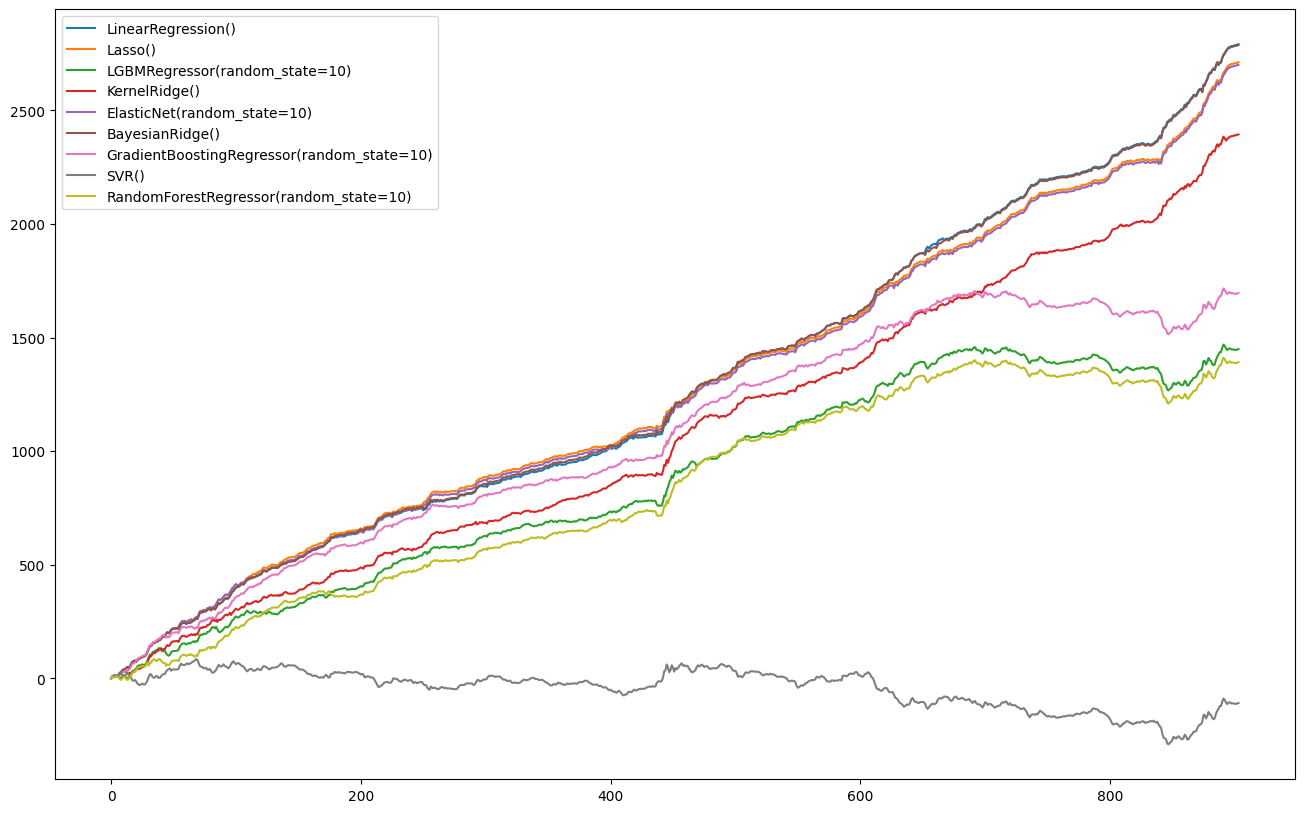

In [ ]:
plt.figure(figsize=(16, 10))

for col in columns_res:

    eq = []
    depo = 0
    for i in results[col]:

        if not math.isnan(i):
            depo = depo + i
            eq.append(depo)
    plt.plot(eq)
    plt.legend(reg_models_metrics.model)

Проанализировав табличку с метриками и графики кривых можно выбрать топ:
- LinearRegression
- Lasso
- ElasticNet
- BayesianRidge

У них минимальные метрики ошибки и максимальные r2, количество удачных сделок намного больше неудачных, самая большая общая сумма и стабильный рост кривой доходности.

В качестве финальной модели выберу модель линейной регресии, как самую простую и понятную.



# Финальная модель

Модель будет предсказывать цены закрытия, максимальную и минимальную.

In [ ]:
# модель для предсказания CLOSE
model_close = LinearRegression()

# предикторы
X_close = data.drop(columns=['TICKER', 'DATE', 'TARGET_CLOSE', 'TARGET_HIGH', 'TARGET_LOW', 'TARGET_UP_DOWN'])
# целевой признак
y_close = data['TARGET_CLOSE']

# разделим на трейн и тест без перемешивания
# учимся на более ранних данных, тестируем на более поздних
X_close_train, X_close_test, y_close_train, y_close_test = train_test_split(X_close, y_close, test_size=0.3, shuffle=False)

model_close.fit(X_close_train, y_close_train)

y_close_pred = model_close.predict(X_close_test)    
print('mae =', mae(y_close_test[:-1], y_close_pred[:-1]))
print('me =', me(y_close_test[:-1], y_close_pred[:-1]))
print('r2 =', r2_score(y_close_test[:-1], y_close_pred[:-1]))

# коэффициенты модели
coef_table = pd.DataFrame(list(X_close_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model_close.coef_)
coef_table.sort_values(by='Coefs', ascending=False)

mae = 2.9101155823037947
me = 28.28146036543734
r2 = 0.9928796204203083


,0,Coefs
34,OPEN_TODAY,1.129
40,DAY_OF_WEEK_5,0.557
42,MONTH_1,0.330
21,LOW-1,0.294
0,OPEN,0.258
52,MONTH_11,0.252
31,LOW-3,0.236
3,CLOSE,0.202
17,LOW_4,0.145
48,MONTH_7,0.113


In [ ]:
# модель для предсказания HIGH
model_high = LinearRegression()

# предикторы
X_high = data.drop(columns=['TICKER', 'DATE', 'TARGET_HIGH', 'TARGET_CLOSE', 'TARGET_LOW', 'TARGET_UP_DOWN'])
# целевой признак
y_high = data['TARGET_HIGH']

# разделим на трейн и тест без перемешивания
# учимся на более ранних данных, тестируем на более поздних
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.3, shuffle=False)

model_high.fit(X_high_train, y_high_train)

y_high_pred = model_high.predict(X_high_test)    
print('mae =', mae(y_high_test[:-1], y_high_pred[:-1]))
print('me =', me(y_high_test[:-1], y_high_pred[:-1]))
print('r2 =', r2_score(y_high_test[:-1], y_high_pred[:-1]))

# коэффициенты модели
coef_table = pd.DataFrame(list(X_high_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model_high.coef_)
coef_table.sort_values(by='Coefs', ascending=False)

mae = 1.786373892179456
me = 19.425079224232462
r2 = 0.9972747574786175


,0,Coefs
34,OPEN_TODAY,0.929
40,DAY_OF_WEEK_5,0.568
41,DAY_OF_WEEK_6,0.354
52,MONTH_11,0.193
42,MONTH_1,0.189
14,HIGH_5,0.174
20,HIGH-1,0.168
3,CLOSE,0.166
29,OPEN-3,0.122
0,OPEN,0.110


In [ ]:
# модель для предсказания LOW
model_low = LinearRegression()

# предикторы
X_low = data.drop(columns=['TICKER', 'DATE', 'TARGET_HIGH', 'TARGET_CLOSE', 'TARGET_LOW', 'TARGET_UP_DOWN'])
# целевой признак
y_low = data['TARGET_LOW']

# разделим на трейн и тест без перемешивания
# учимся на более ранних данных, тестируем на более поздних
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=0.3, shuffle=False)

model_low.fit(X_low_train, y_low_train)

y_low_pred = model_low.predict(X_low_test)    
print('mae =', mae(y_low_test[:-1], y_low_pred[:-1]))
print('me =', me(y_low_test[:-1], y_low_pred[:-1]))
print('r2 =', r2_score(y_low_test[:-1], y_low_pred[:-1]))

# коэффициенты модели
coef_table = pd.DataFrame(list(X_low_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model_low.coef_)
coef_table.sort_values(by='Coefs', ascending=False)

mae = 1.815044316405406
me = 15.723205855792742
r2 = 0.9970230602445588


,0,Coefs
34,OPEN_TODAY,1.190
41,DAY_OF_WEEK_6,0.233
16,LOW_3,0.204
42,MONTH_1,0.169
31,LOW-3,0.167
50,MONTH_9,0.141
51,MONTH_10,0.141
0,OPEN,0.099
48,MONTH_7,0.095
19,OPEN-1,0.074
